In [12]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore, mannwhitneyu
from msresist.figures.figureM2 import TumorType
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})
from msremsresist.pre_processing import preprocessing


ModuleNotFoundError: No module named 'msremsresist'

In [7]:
def FixColumnLabels(cv):
    """ Fix column labels to use pandas locators. """
    l = []
    for label in cv[0].columns:
        if "-" not in label and label != "Elapsed":
            l.append(label + "-UT")
        if "-" in label or label == "Elapsed":
            l.append(label)

    for d in cv:
        d.columns = l

    return cv

def y_pre(ds, tr, ftp, phenotype, all_lines, itp=False):
    """ Preprocesses cell phenotype data sets for analysis. """
    z = []
    for sl in ds:
        c = sl.loc[:, sl.columns.str.contains(tr)]
        c.insert(0, "Elapsed", ds[0].iloc[:, 0])
        c = c[list(c.columns[:3]) + [c.columns[4]] + [c.columns[3]] + list(c.columns[5:])]
        if not isinstance(itp, bool):
            c = c[c["Elapsed"] == ftp].iloc[0, 1:].div(c[c["Elapsed"] == itp].iloc[0, 1:])
        else:
            c = c[c["Elapsed"] == ftp].iloc[0, 1:]
        z.append(c)

    y = pd.DataFrame(pd.concat(z, axis=0)).reset_index()
    y.columns = ["Lines", phenotype]
    y = y.groupby("Lines").mean().T[c.index].T.reset_index()

    y["Lines"] = [s.split(tr)[0] for s in y.iloc[:, 0]]
    y["Treatment"] = tr

    if "-" in y["Lines"][1]:
        y["Lines"] = [s.split("-")[0] for s in y.iloc[:, 0]]

    y["Lines"] = all_lines
    return y[["Lines", "Treatment", phenotype]]

In [10]:

X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=["float64"]).T

all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]

d.index = all_lines

cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv")
cv3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv")
cv4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv")

itp = 24
ftp = 96

cv = [cv1, cv2, cv3, cv4]
cv = FixColumnLabels(cv)

v_ut = y_pre(cv, "UT", ftp, "Viability", all_lines, itp=itp)
v_e = y_pre(cv, "-E", ftp, "Viability", all_lines, itp=itp)
v_ae = y_pre(cv, "A/E", ftp, "Viability", all_lines, itp=itp)

# Cell Death
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

for jj in range(1, red1.columns.size):
    red1.iloc[:, jj] /= cv1.iloc[:, jj]
    red2.iloc[:, jj] /= cv2.iloc[:, jj]
    red3.iloc[:, jj] /= cv3.iloc[:, jj]
    red4.iloc[:, jj] /= cv4.iloc[:, jj]

cD = [red1, red2, red3, red4]
cD = FixColumnLabels(cD)
cd_ut = y_pre(cD, "UT", ftp, "Apoptosis", all_lines, itp=itp)
cd_e = y_pre(cD, "-E", ftp, "Apoptosis", all_lines, itp=itp)
cd_ae = y_pre(cD, "A/E", ftp, "Apoptosis", all_lines, itp=itp)

r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR1_RWD.csv")
r2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
r3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
r4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")
ftp = 12
cm = [r1, r2, r3, r4]
m_ut = y_pre(cm, "UT", ftp, "Migration", all_lines)
m_e = y_pre(cm, " E", ftp, "Migration", all_lines)
m_ae = y_pre(cm, "A/E", ftp, "Migration", all_lines)

m_ut.index = v_ut.index
m_e.index = v_e.index
m_ae.index = v_ae.index

# Clustering Effect
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
radius = np.linspace(1, 14.67, 1)
folder = '48hrs'
c = DataFrameRipleysK(folder, mutants, treatments, replicates, radius).reset_index().set_index("Mutant")
c.columns = ["Treatment", "Island"]
c_ut = c[c["Treatment"] == "ut"]
c_ut = c_ut.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ut.index = all_lines
c_ut = c_ut.reset_index()
c_ut["Treatment"] = "UT"

c_e = c[c["Treatment"] == "e"]
c_e = c_e.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_e.index = all_lines
c_e = c_e.reset_index()
c_e["Treatment"] = "E"

c_ae = c[c["Treatment"] == "ae"]
c_ae = c_ae.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ae.index = all_lines
c_ae = c_ae.reset_index()
c_ae["Treatment"] = "A/E"

# -------- PLOTS -------- #
# PCA analysis of phenotypes
y_ae = pd.concat([v_ae, cd_ae["Apoptosis"], m_ae["Migration"], c_ae["Island"]], axis=1)
y_e = pd.concat([v_e, cd_e["Apoptosis"], m_e["Migration"], c_ae["Island"]], axis=1)
y_ut = pd.concat([v_ut, cd_ut["Apoptosis"], m_ut["Migration"], c_ae["Island"]], axis=1)

y_c = pd.concat([y_ut, y_e, y_ae])
y_c.iloc[:, 2:] = StandardScaler().fit_transform(y_c.iloc[:, 2:])

plotPCA(ax[:2], y_c, 3, ["Lines", "Treatment"], "Phenotype", hue_scores="Lines", style_scores="Treatment", legendOut=True)

NameError: name 'preprocessing' is not defined

In [289]:
with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
        model = pickle.load(p)[0]

In [396]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv")
mOI = mutations[["Sample.ID"] + list(mutations.columns)[45:54] + list(mutations.columns)[61:64]]
mOI = mOI[~mOI["Sample.ID"].str.contains("IR")]

In [482]:
cc["TP53 status"] = merge_binary_vectors(y, "EGFR.mutation.status", "ALK.fusion").iloc[cc.index]

In [484]:
pvals = build_pval_matrix(calculate_mannW_pvals(cc, "TP53 status", 1, 0), model.ncl)

<AxesSubplot:xlabel='p-value', ylabel='Clusters'>

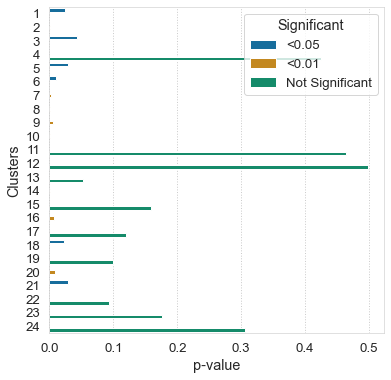

In [485]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.barplot(x="p-value", y="Clusters", data=pvals, hue="Significant", orient="h")

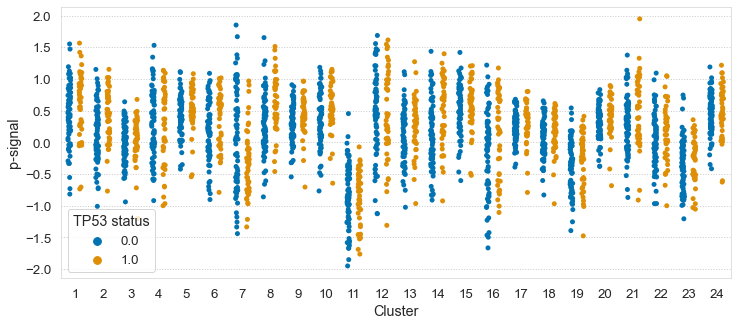

In [486]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_clusters_binaryfeatures(cc, "TP53 status", ax)

## Regression against methylation

In [158]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv").sort_values(by="Sample.ID").set_index("Sample.ID")
mtl = mutations["CIMP.status"]
mtl = mtl[~mtl.index.str.contains("IR")]

In [159]:
centers = pd.DataFrame(model.transform())
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers["Patient_ID"] = X.columns[4:]
centers = centers.set_index("Patient_ID").sort_values(by="Patient_ID")
assert all(mtl.index == centers.index), "sampels not matching"

In [160]:
centers["drop"] = pd.isnull(mtl).values
centers = centers[centers["drop"] == False]

mtl = mtl.dropna().
assert all(centers.index == mtl.index), "samples not matching."